In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0005.hk',"2017-09-28","2021-09-24")
# data.drop("Adj Close",axis=1,inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,64.387001,22520013
2017-09-29,76.500000,76.900002,76.300003,76.550003,64.682732,16766252
2017-10-03,76.800003,77.449997,76.699997,77.449997,65.443199,24369212
2017-10-04,77.500000,77.949997,77.500000,77.849998,65.781189,21197563
2017-10-06,77.599998,77.800003,77.199997,77.349998,65.358704,23715110


In [3]:
data.shift(1).head(90)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-29,76.400002,77.099998,76.050003,76.199997,64.387001,22520013.0
2017-10-03,76.500000,76.900002,76.300003,76.550003,64.682732,16766252.0
2017-10-04,76.800003,77.449997,76.699997,77.449997,65.443199,24369212.0
2017-10-06,77.500000,77.949997,77.500000,77.849998,65.781189,21197563.0
...,...,...,...,...,...,...
2018-02-01,83.449997,84.500000,83.000000,84.199997,71.864357,36516373.0
2018-02-02,83.500000,84.150002,83.449997,84.050003,71.736336,33272295.0
2018-02-05,83.550003,84.000000,83.250000,83.699997,71.437607,21777829.0


In [4]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].shift(1).pct_change()
data['3day MA'] = data['Close'].shift(1).rolling(window = 3).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window = 10).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window = 30).mean()
data['Std_dev']= data['Close'].shift(1).rolling(5).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 9)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'H-L', 'O-C',
       '% Change', '3day MA', '10day MA', '30day MA', 'Std_dev'],
      dtype='object')

In [5]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [6]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [7]:
data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
# data=data
# data.drop(["Volume","Adj Close"], axis=1,inplace=True)

In [8]:
data.dropna(inplace=True)
data.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
H-L                0
O-C                0
% Change           0
3day MA            0
10day MA           0
30day MA           0
Std_dev            0
 Put/Call Ratio    0
dtype: int64

In [9]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev,Put/Call Ratio
2020-09-28,28.350000,31.299999,28.250000,30.799999,29.670927,150402170,3.049999,2.449999,-0.013986,28.516667,30.140,32.380000,0.394334,0.8373
2020-09-29,30.850000,31.400000,30.000000,30.000000,28.900255,55920302,1.400000,-0.850000,0.092199,29.200000,30.000,32.253334,1.023718,1.3801
2020-09-30,30.500000,30.500000,29.650000,29.799999,28.707586,35285507,0.850000,-0.700001,-0.025974,29.666667,29.795,32.111667,1.088347,1.4973
2020-10-05,30.700001,31.900000,30.700001,31.000000,29.863596,69650604,1.199999,0.299999,-0.006667,30.199999,29.600,31.966667,1.063954,0.8662
2020-10-06,31.100000,31.200001,30.750000,31.049999,29.911764,28877682,0.450001,-0.050001,0.040268,30.266666,29.610,31.878333,1.108151,1.0145


In [10]:
data_price=data["Close"]
train=data.shift(1).dropna().values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb-1,len(data)-lb-1):
        X.append(data[i-(lb-1):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=7
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)].reshape(-1,1),y[int(y.shape[0]*0.90):].reshape(-1,1)
# print(type(X_train))
print(X[0])
print(y[0])
print(data.shape)

[[0.00000000e+00 4.86618023e-02 0.00000000e+00 4.76190476e-02
  4.49017863e-02 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.97370190e-01 0.00000000e+00 2.74809238e-02 8.79948069e-02
  1.22510027e-01 1.05023874e-01]
 [1.15473443e-01 5.35280011e-02 8.29383946e-02 9.52384585e-03
  8.98039283e-03 3.71805154e-01 4.59016383e-01 1.64556913e-01
  1.00000000e+00 3.18817935e-02 2.03562341e-02 8.09329239e-02
  4.24186924e-01 2.17708117e-01]
 [9.93071435e-02 9.73239758e-03 6.63506976e-02 0.00000000e+00
  0.00000000e+00 2.34607699e-01 2.78688719e-01 2.02531511e-01
  1.06755035e-01 5.36547278e-02 9.92366800e-03 7.30347638e-02
  4.55164832e-01 2.42038613e-01]
 [1.08545054e-01 7.78589022e-02 1.16113789e-01 5.71428935e-02
  5.38821792e-02 4.63095739e-01 3.93442346e-01 4.55696141e-01
  2.52695531e-01 7.85380644e-02 0.00000000e+00 6.49507604e-02
  4.43472959e-01 1.11023459e-01]
 [1.27020787e-01 4.37956963e-02 1.18483421e-01 5.95238095e-02
  5.61273218e-02 1.92003094e-01 1.47541271e-01 3.67088424e-01


In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(206, 6, 14) (206, 1) (23, 6, 14) (23, 1)


In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(Dense(32))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [13]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 100)            46000     
_________________________________________________________________
dropout (Dropout)            (None, 6, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 126,501
Trainable params: 126,501
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Fit model with history to check for overfitting
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=300,batch_size=20,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/300
11/11 [==============================] - 11s 56ms/step - loss: 1609.9190 - val_loss: 1555.2273
Epoch 2/300
11/11 [==============================] - 0s 7ms/step - loss: 1299.2666 - val_loss: 960.2477
Epoch 3/300
11/11 [==============================] - 0s 6ms/step - loss: 828.5195 - val_loss: 736.9141
Epoch 4/300
11/11 [==============================] - 0s 6ms/step - loss: 636.3002 - val_loss: 651.7346
Epoch 5/300
11/11 [==============================] - 0s 7ms/step - loss: 565.9675 - val_loss: 586.5308
Epoch 6/300
11/11 [==============================] - 0s 7ms/step - loss: 504.9313 - val_loss: 529.0468
Epoch 7/300
11/11 [==============================] - 0s 6ms/step - loss: 458.6149 - val_loss: 476.7950
Epoch 8/300
11/11 [==============================] - 0s 7ms/step - loss: 413.8917 - val_loss: 429.5244
Epoch 9/300
11/11 [==============================] - 0s 7ms/step - loss: 364.8714 - val_loss: 386.6896
Epoch 10/300
11/11 [==============================] - 0s 6ms/step - 

In [15]:
y_pred = model.predict(X_test)

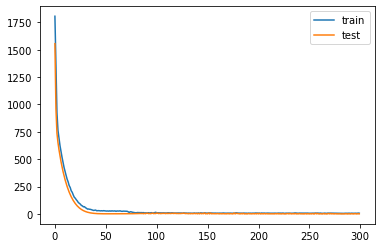

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

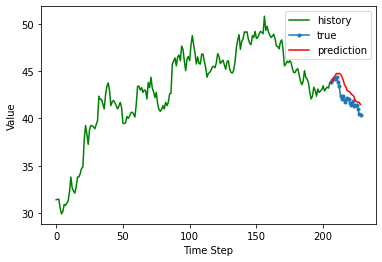

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test

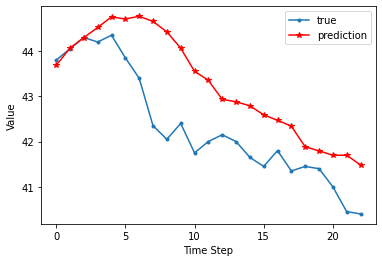

In [19]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [20]:
mean_absolute_percentage_error(y_test,y_pred)*100

2.2828154052558225

In [21]:
mean_squared_error(y_test,y_pred)

1.333252291615202

In [22]:
y_pred_lstm_final = np.zeros((len(y_pred)-1,))
y_test_t_final = np.zeros((len(y_test)-1,))
for i in range(len(y_pred)-1):
    if y_pred[i+1] >= y_pred[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test)-1):
    if y_test[i+1] >= y_test[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
Predicted direction accuracy (Up/down):
0.6363636363636364
